In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
import os

from sklearn.metrics import classification_report
import tensorflow.keras.backend as K

from tensorflow.keras import layers

E0000 00:00:1753431396.138184      10 common_lib.cc:612] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: === 
learning/45eac/tfrc/runtime/common_lib.cc:230


In [ ]:
# Config 
INPUT_DIR = Path("/kaggle/working/output_wav2vec_custom_augmented")
OUTPUT_DIR = Path("./output_tfmr_class_tpu")
OUTPUT_DIR.mkdir(exist_ok=True)

MAX_SEQ_LEN = 150
EMBEDDING_DIM = 768
LABEL_COLS = ['Prolongation', 'Block', 'SoundRep', 'WordRep', 'Interjection']
NUM_CLASSES = len(LABEL_COLS)

BATCH_SIZE_PER_REPLICA = 16
EPOCHS = 400
LEARNING_RATE = 1e-5
THRESHOLD = 0.5

TRAIN_DATA_PATH = INPUT_DIR / "train_data.npz"
VAL_DATA_PATH = INPUT_DIR / "val_data.npz"
TEST_DATA_PATH = INPUT_DIR / "test_data.npz"
OUTPUT_DIR = Path("./")
BEST_MODEL_PATH = OUTPUT_DIR / "best_tfmr_model.keras"


In [ ]:
print("--- Initializing TPU Strategy ---")

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='local')
    # tf.config.experimental_connect_to_cluster(tpu)
    # tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
    
    print('TPU successfully initialized. Found TPU: ', tpu.master())
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync
    print(f"Global batch size set to: {BATCH_SIZE}")
    print("Number of replicas:", strategy.num_replicas_in_sync)

except Exception as e:
    print(f"TPU initialization failed, this is the error: {e}")
    print("Falling back to default strategy (CPU/GPU).")
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA


--- Initializing TPU Strategy ---
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


TPU successfully initialized. Found TPU:  
Global batch size set to: 128
Number of replicas: 8


In [ ]:
print("\nLoading all compressed features")

train_data = np.load(TRAIN_DATA_PATH)
val_data = np.load(VAL_DATA_PATH)
test_data = np.load(TEST_DATA_PATH)

# Access the arrays by the keys we used when saving ('x' and 'y')
X_train, y_train = train_data['x'], train_data['y']
X_val, y_val = val_data['x'], val_data['y']
X_test, y_test = test_data['x'], test_data['y']


print("All compressed data loaded successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")



Loading all compressed features
All compressed data loaded successfully.
X_train shape: (33945, 150, 768)
y_train shape: (33945, 6)


In [ ]:
# Remove the last column ('NoStutter') from the labels
y_train = y_train[:, :-1]
y_val = y_val[:, :-1]
y_test = y_test[:, :-1]

# Filter out samples that now have NO labels
train_indices = np.where(y_train.sum(axis=1) > 0)[0]
val_indices = np.where(y_val.sum(axis=1) > 0)[0]
test_indices = np.where(y_test.sum(axis=1) > 0)[0]

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_val, y_val = X_val[val_indices], y_val[val_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

print("Data loaded and modified successfully.")
print(f"New X_train shape: {X_train.shape}")


Data loaded and modified successfully.
New X_train shape: (29783, 150, 768)


In [ ]:
print("\n Verifying final training set distribution after augmentation")

final_train_labels_df = pd.DataFrame(y_train, columns=LABEL_COLS)

print("Final distribution of labels in the training set (including augmented samples):")
print(final_train_labels_df.sum().sort_values(ascending=False))



 Verifying final training set distribution after augmentation
Final distribution of labels in the training set (including augmented samples):
Block           10848
Interjection    10824
Prolongation    10800
SoundRep        10576
WordRep         10569
dtype: int64


In [ ]:
print("\nBuilding tf.data pipeline")

def prepare_dataset(X, y, shuffle=False, drop_remainder = False):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    ds = ds.cache()
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    ds = ds.batch(BATCH_SIZE, drop_remainder=drop_remainder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_dataset = prepare_dataset(X_train, y_train, shuffle=True, drop_remainder=True)
val_dataset = prepare_dataset(X_val, y_val, shuffle=False, drop_remainder=True)
test_dataset = prepare_dataset(X_test, y_test, shuffle=False, drop_remainder=True)
print("Datasets created successfully.")



Building tf.data pipeline
Datasets created successfully.


In [ ]:
with strategy.scope():
    print("\nBuilding Transformer Model")
    # Transformer Encoder Block 
    def transformer_encoder(x, num_heads=4, ff_dim=128, dropout=0.1):
        # Attention and Normalization
        x_attn = layers.LayerNormalization(epsilon=1e-6)(x)
        x_attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=EMBEDDING_DIM // num_heads)(x_attn, x_attn)
        x_attn = layers.Dropout(dropout)(x_attn)
        x = x + x_attn # Residual connection

        # Feed Forward Network
        x_ff = layers.LayerNormalization(epsilon=1e-6)(x)
        x_ff = layers.Dense(ff_dim, activation="relu")(x_ff)
        x_ff = layers.Dropout(dropout)(x_ff)
        x_ff = layers.Dense(EMBEDDING_DIM)(x_ff)
        x = x + x_ff # Residual connection
        
        return x

    def build_transformer_classifier(input_shape, num_classes):
        inputs = layers.Input(shape=input_shape)
        x = inputs
        
        # Applies Transformer encoder blocks
        x = transformer_encoder(x, num_heads=4, ff_dim=256)
        # x = transformer_encoder(x, num_heads=4, ff_dim=256)
        
        # Pool the sequence to a single vector
        x = layers.GlobalAveragePooling1D()(x)
        
        # Classifier head
        x = layers.Dense(128, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='sigmoid')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        
        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE, clipnorm=1.0)
        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc', multi_label=True)]
        )
        return model

    model = build_transformer_classifier(input_shape=(MAX_SEQ_LEN, EMBEDDING_DIM), num_classes=NUM_CLASSES)

model.summary()

checkpoint = tf.keras.callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_auc', mode='max', save_best_only=True, verbose=1)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)

print(f"LEARNING RATE: {LEARNING_RATE}")
print(f"BATCH SIZE: {BATCH_SIZE}")

In [36]:
print("\nStarting Training on TPU")
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[checkpoint, early_stopping]
)


Starting Training on TPU
Epoch 1/400


I0000 00:00:1753439871.663719      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:5797479858960827497
I0000 00:00:1753439872.812111    1003 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(18410379085679345843), session_name()
I0000 00:00:1753439884.237917    1003 tpu_compile_op_common.cc:245] Compilation of 18410379085679345843 with session name  took 11.425759281s and succeeded
I0000 00:00:1753439884.282578    1003 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(18410379085679345843), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_5797479858960827497", property.function_library_fingerprint = 15286815899787463751, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap(

231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2600 - auc: 0.5672 - loss: 0.6829 - precision: 0.4598 - recall: 0.2402

I0000 00:00:1753439906.553347      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:92340764193293131
I0000 00:00:1753439906.774296     958 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(2400632065753270583), session_name()
I0000 00:00:1753439908.872304     958 tpu_compile_op_common.cc:245] Compilation of 2400632065753270583 with session name  took 2.097956044s and succeeded
I0000 00:00:1753439908.877475     958 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(2400632065753270583), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_92340764193293131", property.function_library_fingerprint = 5396656436964965006, property.mlir_module_fingerprint = 0, property.num_replicas = 8, topology.chip_bounds().x = 2, topology.chip_bounds().y = 2, topology.chip_bounds().z = 1, topology.wrap().x = false, topology.wrap().y = false, topology.wrap().z = fal


Epoch 1: val_auc improved from -inf to 0.65441, saving model to best_tfmr_model.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 59s 114ms/step - accuracy: 0.2599 - auc: 0.5674 - loss: 0.6826 - precision: 0.4601 - recall: 0.2397 - val_accuracy: 0.1719 - val_auc: 0.6544 - val_loss: 0.6498 - val_precision: 0.6047 - val_recall: 0.1516
Epoch 2/400
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2829 - auc: 0.6282 - loss: 0.6250 - precision: 0.5674 - recall: 0.2440
Epoch 2: val_auc improved from 0.65441 to 0.67954, saving model to best_tfmr_model.keras
232/232 ━━━━━━━━━━━━━━━━━━━━ 36s 96ms/step - accuracy: 0.2829 - auc: 0.6284 - loss: 0.6250 - precision: 0.5674 - recall: 0.2441 - val_accuracy: 0.1543 - val_auc: 0.6795 - val_loss: 0.6478 - val_precision: 0.5169 - val_recall: 0.2725
Epoch 3/400
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3064 - auc: 0.6576 - loss: 0.6124 - precision: 0.5914 - recall: 0.2946
Epoch 3: val_auc improved from 0.67954 to 0.68945, saving model to best_tfmr_mo


--- Evaluating Model on the Test Set ---


I0000 00:00:1753441065.549454      10 encapsulate_tpu_computations_pass.cc:266] Subgraph fingerprint:2747400145076919813
E0000 00:00:1753441065.573451      10 meta_optimizer.cc:966] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node functional_7_1/dense_30_1/BiasAdd/ReadVariableOp.
I0000 00:00:1753441065.648640    1015 tpu_compilation_cache_interface.cc:442] TPU host compilation cache miss: cache_key(1984847870621938588), session_name()
I0000 00:00:1753441067.399415    1015 tpu_compile_op_common.cc:245] Compilation of 1984847870621938588 with session name  took 1.750714084s and succeeded
I0000 00:00:1753441067.402866    1015 tpu_compilation_cache_interface.cc:476] TPU host compilation cache: compilation complete for cache_key(1984847870621938588), session_name(), subgraph_key(std::string(property.function_name) = "cluster_one_step_on_data_distributed_2747400145076919813", property.function_library_fingerprint = 7120798264050938388, property.mlir_module_fingerpr

54/54 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step

--- Classification Report (5 Stuttering Classes) ---
              precision    recall  f1-score   support

Prolongation       0.68      0.39      0.50      2608
       Block       0.65      0.37      0.47      3474
    SoundRep       0.60      0.47      0.53      1877
     WordRep       0.51      0.52      0.51      1735
Interjection       0.84      0.65      0.73      3333

   micro avg       0.67      0.48      0.56     13027
   macro avg       0.66      0.48      0.55     13027
weighted avg       0.68      0.48      0.56     13027
 samples avg       0.61      0.50      0.51     13027


--- Generating plots for model training history... ---


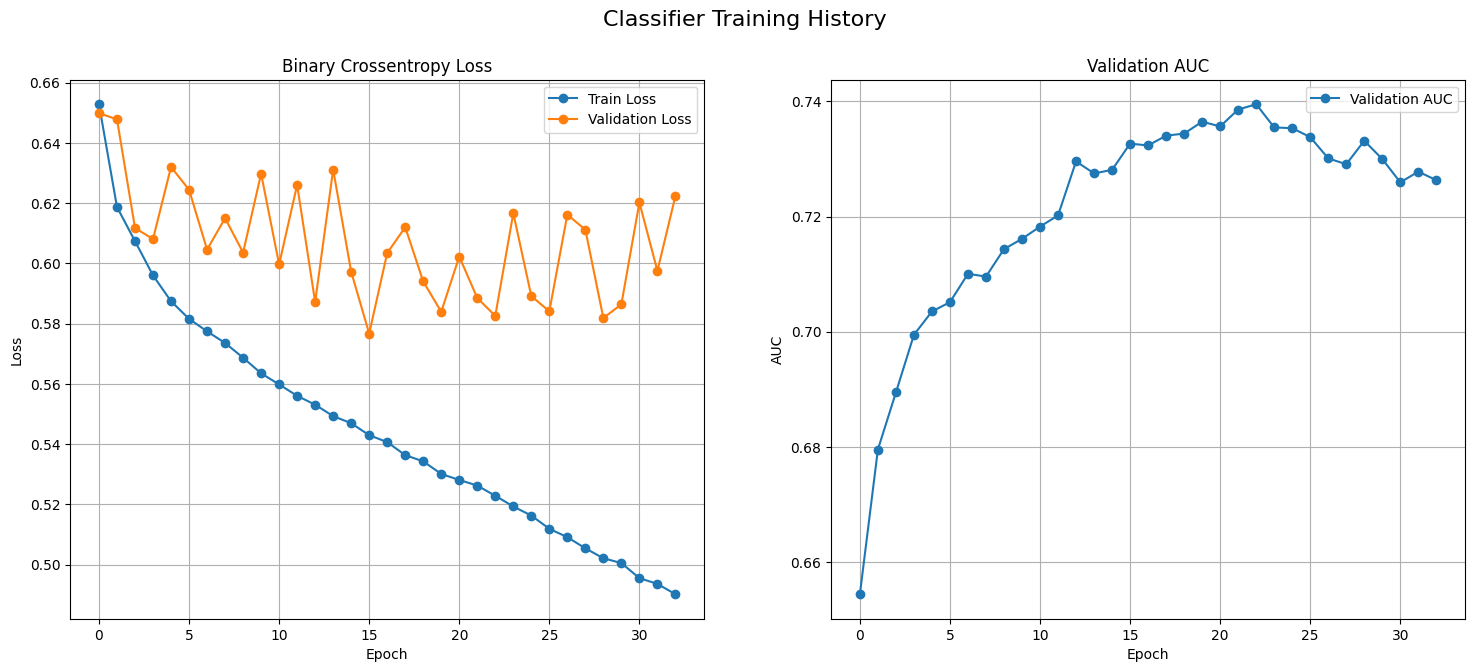

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, precision_recall_curve, average_precision_score
import itertools

print("\n--- Evaluating Model on the Test Set ---")
y_pred_probs = model.predict(test_dataset)
y_pred_binary = (y_pred_probs > THRESHOLD).astype(int)

num_predictions = len(y_pred_binary)
y_test_eval = y_test[:num_predictions]

print("\n--- Classification Report (5 Stuttering Classes) ---")
report = classification_report(y_test_eval, y_pred_binary, target_names=LABEL_COLS, zero_division=0)
print(report)
with open(OUTPUT_DIR / "classification_report.txt", "w") as f:
    f.write(report)

print("\n--- Generating plots for model training history... ---")
history_dict = history.history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Classifier Training History', fontsize=16)
ax1.plot(history_dict['loss'], 'o-', label='Train Loss')
ax1.plot(history_dict['val_loss'], 'o-', label='Validation Loss')
ax1.set_title('Binary Crossentropy Loss'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss'); ax1.legend(); ax1.grid(True)
ax2.plot(history_dict['val_auc'], 'o-', label='Validation AUC')
ax2.set_title('Validation AUC'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('AUC'); ax2.legend(); ax2.grid(True)
plt.savefig(OUTPUT_DIR / "training_history.png")
plt.show()